In [1]:
# importing the required libraries 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime # to tackle the date time features
from datetime import date
from sklearn.cluster import MiniBatchKMeans
import seaborn as sns #pretty plots
import warnings
sns.set()



In [2]:
#reading the trainign and testing data and storing them as data and test respectively.
data =  pd.read_csv('dataset/train.csv', parse_dates =['pickup_datetime'])
dates=['pickup_datetime']
test = pd.read_csv('dataset/test.csv',parse_dates = ['pickup_datetime'])
data.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [3]:
# checking the types of columns and entries in the data and test.
data.info()
test.info()
#using the describe() function to get and idea about different features and their stats
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 122.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
id                    625134 non-null object
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null datetime64[ns]
passenger_count       625134 non-null

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [4]:
#getting individual components of date time
#converting store_and_fwd_flag to a 0 and 1 from a categorical data as only 2 possible values.
for df in (data,test):
    df['year'] = df['pickup_datetime'].dt.year
    df['month'] = df['pickup_datetime'].dt.month
    df['day'] = df['pickup_datetime'].dt.day
    df['hr'] = df['pickup_datetime'].dt.hour
    df['minute'] = df['pickup_datetime'].dt.minute
    #converting flag into 0 or 1
    df['store_and_fwd_flag'] = 1 * (df.store_and_fwd_flag.values== 'Y')

In [5]:

 
print(data[data['pickup_longitude']<-74.2].shape[0]) #points with longitude out of range, possible outliers
print((data['vendor_id']==2).mean())  #Distribution by vendor id
print((data['store_and_fwd_flag']==1).mean()) #distribution by store_and_fwd_flag
print(data[data['store_and_fwd_flag']==1].shape[0])


82
0.53495026888
0.00551539649154
8045


In [6]:
#converting trip duration to log(trip_duration +1) for rmsle
data = data.assign(log_trip_duration = np.log(data.trip_duration+1)) 


In [7]:
#since ride duration will depend on holiday or workday etc importing nyc 2016 holiday dataset
holiday = pd.read_csv('dataset/NYC_2016Holidays.csv', sep = ';') # secondary dataset for restdays
holiday['Date'] = holiday['Date'].apply(lambda x: x+ '2016')
holidays = [datetime]

In [8]:
#storing restday features into new data frames (will merge them later)
time_data = pd.DataFrame(index = range(len(data)))  
time_test = pd.DataFrame(index = range(len(test)))

In [9]:
# we will list out the weekends and rest days(holidays)
# will return if its a holiday or weekend

from datetime import date
def find_holiday(yr, month, day, holidays):
    holiday =  [None]*len(yr)
    weekend =  [None]*len(yr)
    i = 0 
    for yy,mm,dd in zip(yr, month, day):
        #checking for saturday sunday(6,7), date.isoweekday() returns the day
        weekend[i] = date(yy,mm,dd).isoweekday() in (6,7)
        holiday[i] = weekend[i] or date(yy,mm,dd)  in holidays
        i+=1
    return holiday, weekend
    

In [10]:
#for training data, creating rest_day and weekend columns in a new dataframe (will merge later)
rest_day,weekend = find_holiday(data.year, data.month, data.day, holidays)
time_data = time_data.assign(rest_day = rest_day)
time_data = time_data.assign(weekend = weekend)

#replicating for test data
rest_day,weekend = find_holiday(test.year, test.month, test.day, holidays)
time_test = time_test.assign(rest_day = rest_day)
time_test = time_test.assign(weekend = weekend)

In [11]:
#changing time into floats 
time_data = time_data.assign(pickup_time = data.hr+data.minute/60)
time_test = time_test.assign(pickup_time = test.hr+ test.minute/60)

In [12]:
#using OSRM feature of fastroute (its split into 2 files)
fastrout1 = pd.read_csv('dataset/fastest_routes_train_part_1.csv', usecols=['id','total_distance','total_travel_time','number_of_steps','step_direction'])
fastrout2 = pd.read_csv('dataset/fastest_routes_train_part_2.csv', usecols=['id','total_distance','total_travel_time','number_of_steps','step_direction'])
#merging data from the 2 fastrout files
fastrout = pd.concat((fastrout1,fastrout2))
fastrout.head()

,id,total_distance,total_travel_time,number_of_steps,step_direction
0,id2875421,2009.1,164.9,5,left|straight|right|straight|arrive
1,id2377394,2513.2,332.0,6,none|right|left|right|left|arrive
2,id3504673,1779.4,235.8,4,left|left|right|arrive
3,id2181028,1614.9,140.1,5,right|left|right|left|arrive
4,id0801584,1393.5,189.4,5,right|right|right|left|arrive


In [13]:
#from the data calculating the number for strict lefts and rights
right_turn = []
left_turn = []
right_turn+= list(map(lambda x:x.count('right')-x.count('slight right'), fastrout.step_direction))
left_turn+= list(map(lambda x:x.count('left')-x.count('slight left'), fastrout.step_direction))

In [14]:
# storing the osrm features in a new dataframe (will merge later)
osrm_data = fastrout[['id', 'total_distance', 'total_travel_time','number_of_steps']]
osrm_data = osrm_data.assign(right_steps = right_turn)
osrm_data = osrm_data.assign(left_steps = left_turn)
osrm_data.head(3)

,id,total_distance,total_travel_time,number_of_steps,right_steps,left_steps
0,id2875421,2009.1,164.9,5,1,1
1,id2377394,2513.2,332.0,6,2,2
2,id3504673,1779.4,235.8,4,1,2


In [15]:
# making osrm data compatible to use by mapping ids
data = data.join(osrm_data.set_index('id'), on = 'id')
data.head(3)



,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,month,day,hr,minute,log_trip_duration,total_distance,total_travel_time,number_of_steps,right_steps,left_steps
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,...,3,14,17,24,6.122493,2009.1,164.9,5.0,1.0,1.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,...,6,12,0,43,6.498282,2513.2,332.0,6.0,2.0,2.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,...,1,19,11,35,7.661527,11060.8,767.6,16.0,5.0,4.0


In [16]:
#replicating for test data
osrm_test = pd.read_csv('dataset/fastest_routes_test.csv')
right_turn= list(map(lambda x:x.count('right')-x.count('slight right'),osrm_test.step_direction))
left_turn = list(map(lambda x:x.count('left')-x.count('slight left'),osrm_test.step_direction))

osrm_test = osrm_test[['id','total_distance','total_travel_time','number_of_steps']]
osrm_test = osrm_test.assign(right_steps=right_turn)
osrm_test = osrm_test.assign(left_steps=left_turn)
osrm_test.head(3)

,id,total_distance,total_travel_time,number_of_steps,right_steps,left_steps
0,id0771704,1497.1,200.2,7,2,3
1,id3274209,1427.1,141.5,2,0,0
2,id2756455,2312.3,324.6,9,4,4


In [17]:
test = test.join(osrm_test.set_index('id'), on='id')

In [18]:
osrm_test.head(3)

,id,total_distance,total_travel_time,number_of_steps,right_steps,left_steps
0,id0771704,1497.1,200.2,7,2,3
1,id3274209,1427.1,141.5,2,0,0
2,id2756455,2312.3,324.6,9,4,4


In [19]:
# final osrm features
osrm_data = data[['total_distance','total_travel_time','number_of_steps','right_steps','left_steps']]
osrm_test = test[['total_distance','total_travel_time','number_of_steps','right_steps','left_steps']]

In [20]:
# DISTANCE METRICS
#haversine manhattan and bearing distance
def haversine_array(lat1, lng1, lat2, lng2):
    lat1,lng1,lat2,lng2 = map(np.radians, (lat1,lng1,lat2,lng2))
    earth_radius = 6371 #km
    lat = lat2-lat1
    lng = lng2-lng1
    d = np.sin(lat*0.5) **2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng *0.5)**2
    h = 2 * earth_radius * np.arcsin(np.sqrt(d))
    return h

def manhattan_distance(lat1, lat2, lng1, lng2):
    a = haversine_array(lat1,lng1,lat1,lng2)
    b = haversine_array(lat1,lng1,lat2,lng1)
    return a+b

def bearing_array(lat1, lng1, lat2, lng2):
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))
    
    

In [21]:
#calculating and saving distance features in a new dataframe

List_dist = []
for df in (data,test):
    lat1, lng1, lat2, lng2 = (df['pickup_latitude'].values, df['pickup_longitude'].values, 
                              df['dropoff_latitude'].values,df['dropoff_longitude'].values)
    dist = pd.DataFrame(index=range(len(df)))
    dist = dist.assign(haversine_dist = haversine_array(lat1, lng1, lat2, lng2))
    dist = dist.assign(manhattan_dist = manhattan_distance(lat1, lng1, lat2, lng2))
    dist = dist.assign(bearing = bearing_array(lat1, lng1, lat2, lng2))
    List_dist.append(dist)
Other_dist_data,Other_dist_test = List_dist

In [22]:
##### using k means to make clusters of locations
coord_pickup = np.vstack((data[['pickup_latitude', 'pickup_longitude']].values, test[['pickup_latitude','pickup_longitude']].values))
coord_dropoff = np.vstack((data[['dropoff_latitude', 'dropoff_longitude']].values, test[['dropoff_latitude','dropoff_longitude']].values))

# creating a 4d data for k means
coords = np.hstack((coord_pickup,coord_dropoff))
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=10, batch_size =10000).fit(coords[sample_ind])
for df in (data,test):
    df.loc[:,'pickup_dropoff_loc'] = kmeans.predict(df[['pickup_latitude', 'pickup_longitude',
                                                         'dropoff_latitude','dropoff_longitude']])

In [23]:
# saving location clusters
kmean_data = data[['pickup_dropoff_loc']]
kmean_test = test[['pickup_dropoff_loc']]


In [24]:
# WEATHER DATA
weather = pd.read_csv('dataset/KNYC_Metars.csv', parse_dates=['Time'])
weather.head(5)

,Time,Temp.,Windchill,Heat Index,Humidity,Pressure,Dew Point,Visibility,Wind Dir,Wind Speed,Gust Speed,Precip,Events,Conditions
0,2015-12-31 02:00:00,7.8,7.1,NaN,0.89,1017.0,6.1,8.0,NNE,5.6,0.0,0.8,None,Overcast
1,2015-12-31 03:00:00,7.2,5.9,NaN,0.90,1016.5,5.6,12.9,Variable,7.4,0.0,0.3,None,Overcast
2,2015-12-31 04:00:00,7.2,NaN,NaN,0.90,1016.7,5.6,12.9,Calm,0.0,0.0,0.0,None,Overcast
3,2015-12-31 05:00:00,7.2,5.9,NaN,0.86,1015.9,5.0,14.5,NW,7.4,0.0,0.0,None,Overcast
4,2015-12-31 06:00:00,7.2,6.4,NaN,0.90,1016.2,5.6,11.3,West,5.6,0.0,0.0,None,Overcast


In [25]:
#possible events
print(set(weather.Events))
#assuming snow to play a role with or without fog 

{'Fog\n\t,\nRain', 'None', 'Rain', 'Snow', 'Fog\n\t,\nSnow', 'Fog'}


In [26]:
weather['snow'] = 1*(weather.Events == 'Snow') + 1*(weather.Events == 'Fog\n\t,\nSnow')
weather['year'] = weather['Time'].dt.year
weather['month'] = weather['Time'].dt.month
weather['day'] = weather['Time'].dt.day
weather['hr'] = weather['Time'].dt.hour
weather = weather[weather['year']== 2016][['month','day','hr','Temp.','Precip','snow', 'Visibility']]

In [27]:
weather.head(3)

,month,day,hr,Temp.,Precip,snow,Visibility
22,1,1,0,5.6,0.0,0,16.1
23,1,1,1,5.6,0.0,0,16.1
24,1,1,2,5.6,0.0,0,16.1


In [28]:
# merging weather data by mapping the datetime stamps
data = pd.merge(data, weather, on=['month', 'day', 'hr'], how = 'left')
test = pd.merge(test, weather, on=['month', 'day', 'hr'], how = 'left')

In [29]:
#weather features stored in a new data frame
weather_data = data[['Temp.','Precip','snow','Visibility']]
weather_test = test[['Temp.','Precip','snow','Visibility']]

In [30]:
weather_data.head()

,Temp.,Precip,snow,Visibility
0,4.4,0.3,0.0,8.0
1,28.9,0.0,0.0,16.1
2,-6.7,0.0,0.0,16.1
3,7.2,0.0,0.0,16.1
4,9.4,0.0,0.0,16.1


In [31]:
#DATA Visualization


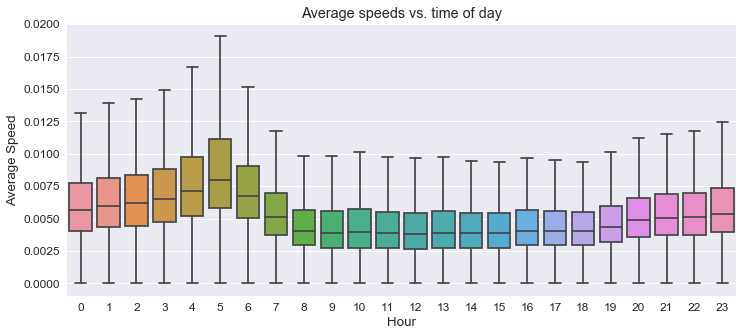

In [32]:
# Calculate the manhattan distance and speed
manhattan = manhattan_distance(data['pickup_latitude'],data['dropoff_latitude'],data['pickup_longitude'],data['dropoff_longitude'])
manhattan_speed = manhattan / data['trip_duration']

# Plot speed against the time of day
sns.set(font_scale=1.2)
plt.figure(figsize=(12, 5))
sns.boxplot(data['hr'], manhattan_speed, showfliers=False)
plt.title('Average speeds vs. time of day')
plt.ylabel('Average Speed')
plt.xlabel('Hour')
plt.show()

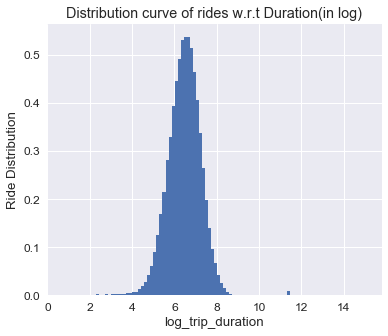

In [33]:
# distributionof trip duration
sns.set(font_scale=1.2)
plt.figure(figsize=(6, 5))
plt.hist(sorted(data['log_trip_duration']), bins=100, normed=True)
plt.title('Distribution curve of rides w.r.t Duration(in log)')
plt.ylabel('Ride Distribution')
plt.xlabel('log_trip_duration')
plt.show()

In [34]:
#Workhours time
tempdata = data
tempdata = pd.concat([tempdata, time_data], axis=1)

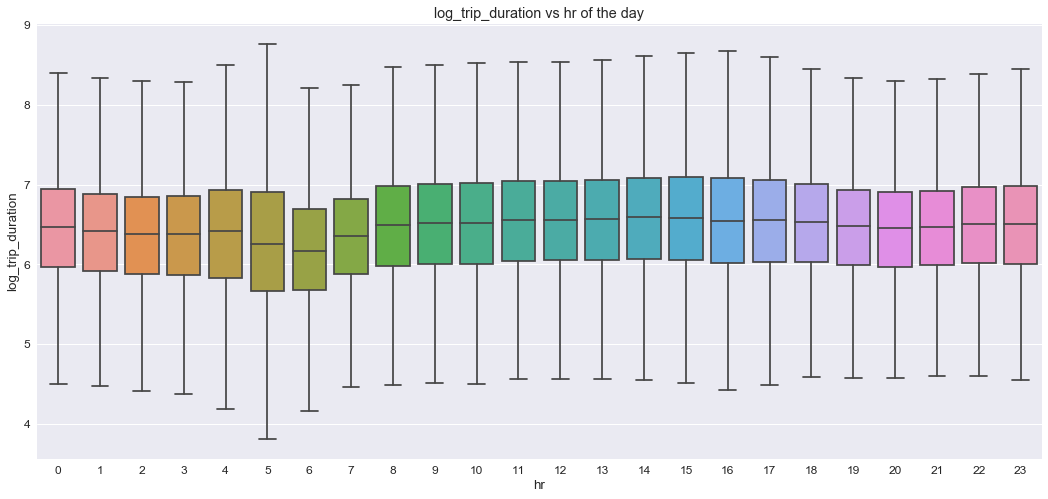

In [35]:
#fig = plt.figure(figsize = (18,8))
sns.set(font_scale=1.2)
plt.figure(figsize=(18, 8))
sns.boxplot(x = "hr", y="log_trip_duration", data = data, showfliers = False)
plt.title("log_trip_duration vs hr of the day")

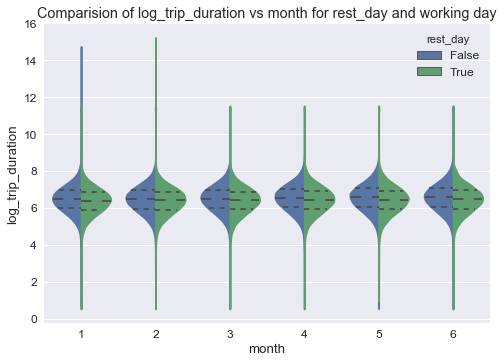

In [36]:
#month vs trip_duration
sns.violinplot(x = "month", y="log_trip_duration", hue = "rest_day", data=tempdata, split=True, inner = "quart")
plt.title("Comparision of log_trip_duration vs month for rest_day and working day")

In [37]:
#THE XGBOOST
# dropping off the target variables
mydf = data[['vendor_id','passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','store_and_fwd_flag']]
testdf = test[['vendor_id','passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','store_and_fwd_flag']]

In [38]:
#converting kmeans data into one hot encoding for XGBOOSTING
kmeans_data = pd.get_dummies(kmean_data.pickup_dropoff_loc, prefix='loc', prefix_sep = '_')
kmeans_test = pd.get_dummies(kmean_test.pickup_dropoff_loc, prefix='loc', prefix_sep = '_')

In [39]:
#merging the entire feature space
mydf  = pd.concat([mydf  ,time_data,weather_data,osrm_data,Other_dist_data,kmeans_data],axis=1)
testdf= pd.concat([testdf,time_test,weather_test,osrm_test,Other_dist_test,kmeans_test],axis=1)

In [40]:
# checking if test and training sets are similar
print(np.all(mydf.keys()==testdf.keys()))

True


In [41]:

X = mydf
z = data['log_trip_duration'].values


In [42]:
# verifying if the keys are similar
print(X.keys() == testdf.keys())

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


In [43]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

C:\Users\akuppal\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [44]:
# 80-20 split for training and validation
Xtrain, Xval, Ztrain, Zval = train_test_split(X, z, test_size=0.2, random_state =42)
#50-50 validation set split
Xcv,Xv,Zcv,Zv = train_test_split(Xval, Zval, test_size=0.5, random_state=1)
#DMatrix conversion for xgb
data_tr  = xgb.DMatrix(Xtrain, label=Ztrain)
data_cv  = xgb.DMatrix(Xcv   , label=Zcv)
evallist = [(data_tr, 'train'), (data_cv, 'valid')]


In [45]:
parms = {'max_depth':15, #maximum depth of a tree 8 12
         'objective':'reg:linear',
         'eta'      :0.05, #0.3
         'subsample':0.9,#SGD will use this percentage of data 0.8 0.99
         'lambda '  :3, #L2 regularization term,>1 more conservative 4 
         'colsample_bytree ':0.6, #0.9
         'colsample_bylevel':0.7, #1 0.7
         'min_child_weight': 0.5, #10 0.5
         #'nthread'  :3 ... default is max cores
         'eval_metric':'rmse'}  #number of cpu core to use
# running for 2k iterations 
model = xgb.train(parms, data_tr, num_boost_round=2000, evals = evallist,
                  early_stopping_rounds=50, maximize=False, 
                  verbose_eval=100)


# The optimization function replacing GridSearchCV implemented with the help of the kaggle kernel of beluga
'''                  

Flag = True
xgb_pars = []
for min_child_weight in [0.5, 1, 2, 4]:
    for ETA in [0.05, 0.1, 0.15]:
        for colsample_bytree in [0.5,0.6,0.7,0.8,0.9]:
            for max_depth in [6, 8, 10, 12, 15]:
                for subsample in [0.5, 0.6, 0.7, 0.8, 0.9]:
                    for lambda in [0.5, 1., 1.5,  2., 3.,4.]:
                        xgb_pars.append({'min_child_weight': min_child_weight, 'eta': ETA,
                                         'colsample_bytree': colsample_bytree, 'max_depth': max_depth,
                                         'subsample': subsample, 'lambda': lambda, 
                                         'eval_metric': 'rmse','silent': 1, 'objective': 'reg:linear'})

while Flag:
    xgb_par = np.random.choice(xgb_pars, 1)[0]
    print(xgb_par)
    model = xgb.train(xgb_par, data_tr, 2000, evallist, early_stopping_rounds=50,maximize=False, verbose_eval=100)
    print('Modeling RMSLE %.6f' % model.best_score)
'''
#the final score achieved by the set parameters and the iterations required for achieveing it (early stopping) 

print('score = %1.5f, n_boost_round =%d.'%(model.best_score,model.best_iteration))

[0]	train-rmse:5.72016	valid-rmse:5.72079
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[100]	train-rmse:0.29356	valid-rmse:0.388537
[200]	train-rmse:0.248939	valid-rmse:0.381138
[300]	train-rmse:0.228276	valid-rmse:0.379718
[400]	train-rmse:0.21446	valid-rmse:0.379016
[500]	train-rmse:0.202478	valid-rmse:0.378518
[600]	train-rmse:0.191081	valid-rmse:0.378151
[700]	train-rmse:0.181557	valid-rmse:0.377872
[800]	train-rmse:0.173574	valid-rmse:0.377684
[900]	train-rmse:0.166302	valid-rmse:0.377556
[1000]	train-rmse:0.158765	valid-rmse:0.377493
[1100]	train-rmse:0.152382	valid-rmse:0.377382
[1200]	train-rmse:0.146716	valid-rmse:0.377352
[1300]	train-rmse:0.140502	valid-rmse:0.377254
[1400]	train-rmse:0.134977	valid-rmse:0.377191
[1500]	train-rmse:0.130151	valid-rmse:0.377179
Stopping. Best iteration:
[1529]	train-rmse:0.128616	valid-rmse:0.377168

score = 0.37717, n_boost_round =1529.


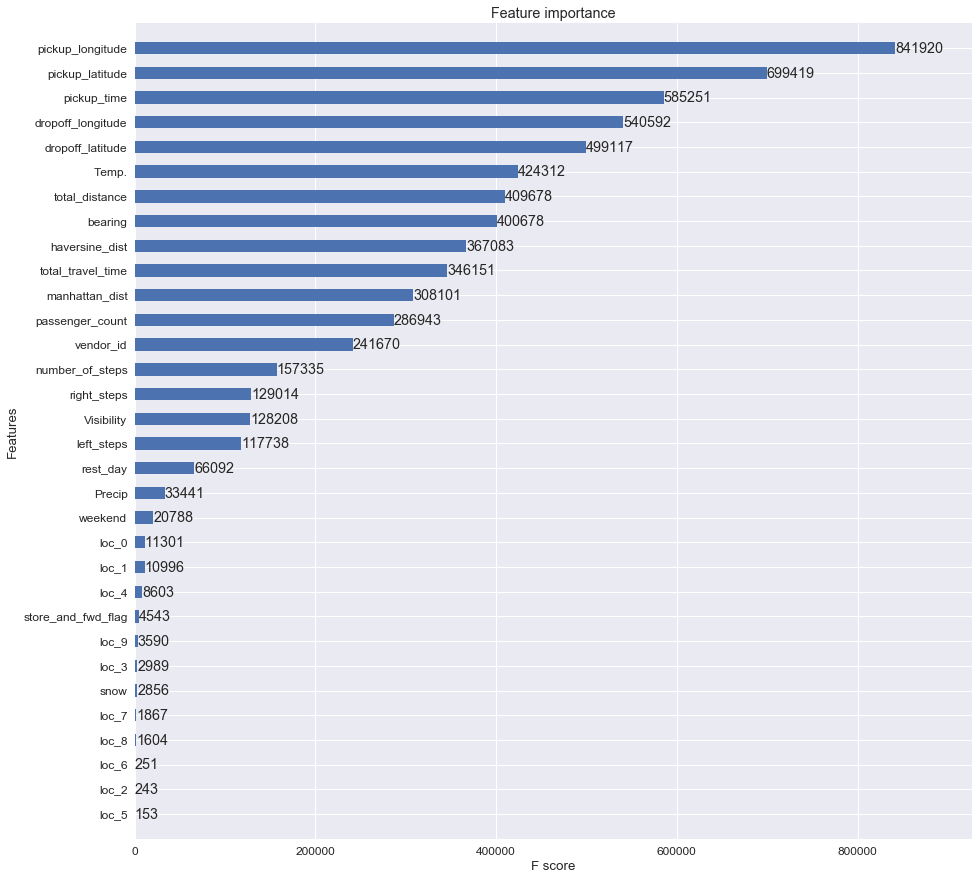

In [46]:
# Feature imporatnce graph using the xgb.plot_importance
fig =  plt.figure(figsize = (15,15))
axes = fig.add_subplot(111)
xgb.plot_importance(model,ax = axes,height =0.5)
plt.show();plt.close()

In [47]:
# prediction using the model from the test data
data_test = xgb.DMatrix(testdf)
ztest = model.predict(data_test)


In [48]:

ytest = np.exp(ztest)-1
print(ytest[:10])

[  766.22845459   578.23187256   399.52279663   947.43713379   363.18490601
   903.98730469  1330.34875488   831.69354248  2717.70849609   554.48382568]


In [49]:
#creating submission for kaggle
submission = pd.DataFrame({'id': test.id, 'trip_duration': ytest})
submission.to_csv('submission.csv', index=False)

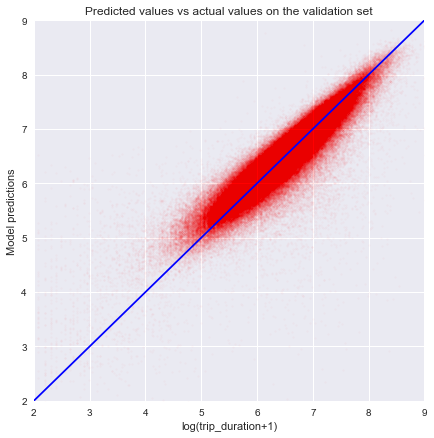

In [50]:
# model evaluation predicted vs actual values on validation set
pred_val = model.predict(xgb.DMatrix(Xval))

sns.set(font_scale=1)
plt.figure(figsize=(7, 7))
plt.scatter(Zval, pred_val, s=3, color='red', alpha=0.025)
plt.plot([1,9],[1,9], color='blue')
plt.title('Predicted values vs actual values on the validation set')
plt.xlabel('log(trip_duration+1)')
plt.ylabel('Model predictions')
axes = plt.gca()
axes.set_xlim([2, 9])
axes.set_ylim([2, 9])
plt.show()
plt.show()